<a href="https://colab.research.google.com/github/chabelicastano/cap4770-spring23/blob/main/Projects/ChabeliCastano_P03_IntelImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


All the following code is me trying to access the file pictures from google drive. Since this was my first time doing such thing, there's a lot of practice involved and I'm sure it could use some simplification.


In [19]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip
!unzip 'drive/MyDrive/intel_img.zip'

In [25]:
# ls
!ls

 drive	     __MACOSX	  'view?usp=share_link'
 intel_img   sample_data  'view?usp=sharing'


In [29]:
# I tried to cd to intel but it didn't work using "!"
!cd intel_img

In [30]:
!ls

 drive	     __MACOSX	  'view?usp=share_link'
 intel_img   sample_data  'view?usp=sharing'


In [31]:
# for working directory
!pwd

/content


In [32]:
# now cd actually worked
%cd intel_img

/content/intel_img


In [33]:
!pwd

/content/intel_img


In [34]:
!ls

seg_pred  seg_test  seg_train


Here, a picture of my files:


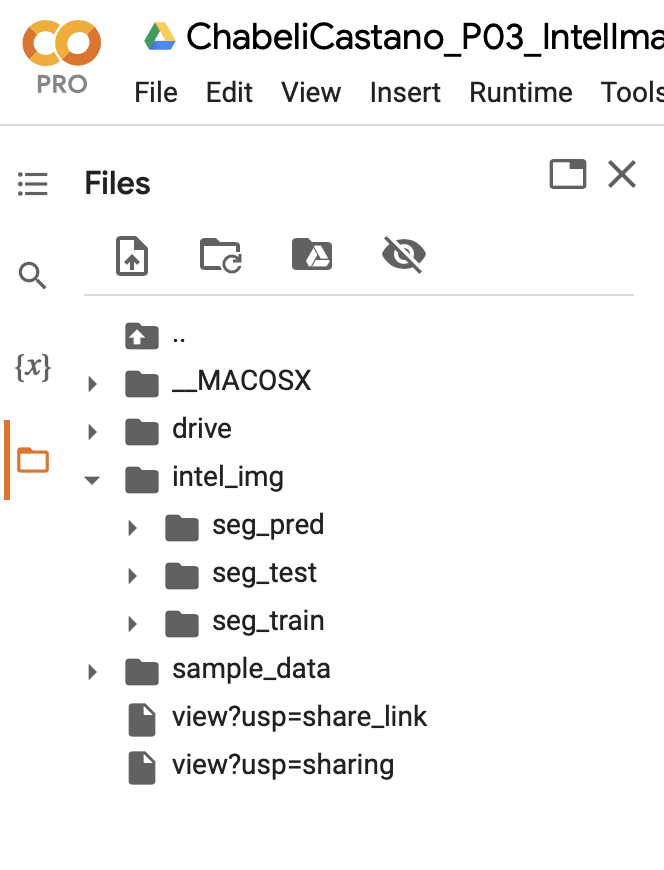

In [65]:
from keras.preprocessing.image import ImageDataGenerator

# Image resizing

# Since we only have labels/classes in seg_train and seg_test
# I will divide the training set into validation and training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.2, 1.6],
                                   # to get the validation_split
                                   validation_split=0.2)

# I will create the validation_datagen anyways. I guess I'll need to
# get results for this data at the end
validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'seg_train',
    target_size=(150, 150),
    batch_size=20,
    class_mode="sparse",
    subset='training')

# test_generator
test_generator = test_datagen.flow_from_directory(
    'seg_test',
    target_size=(150, 150),
    batch_size=20,
    class_mode='sparse')

# validation_generator from training set
validation_generator_1 = train_datagen.flow_from_directory(
    'seg_train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='sparse',
    subset='validation')

# this validation_generator is because I think I'll need to 
# test those images
validation_generator_2 = validation_datagen.flow_from_directory(
    # we don't have the classes for these
    '.', classes=['seg_pred'],
    target_size=(150, 150),
    batch_size=20,
    class_mode='sparse')

Found 11230 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


In [55]:
# Let's create a model
from keras import layers
from keras import models

# Since the input_shape is very similar to the example on the cnn notebook,
# I used a similar approach to construct this model
aug_model = models.Sequential()
# Conv2D layer
aug_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
# MaxPooling2D
aug_model.add(layers.MaxPooling2D((2, 2)))
# Conv2D layer
aug_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# MaxPooling2D
aug_model.add(layers.MaxPooling2D((2, 2)))
# Conv2D layer
aug_model.add(layers.Conv2D(128, (3,3), activation='relu'))
# MaxPooling2D
aug_model.add(layers.MaxPooling2D((2, 2)))

# Flattering
aug_model.add(layers.Flatten())
# Dense layer
aug_model.add(layers.Dropout(0.3))
# Dense
aug_model.add(layers.Dense(512, activation='relu'))
aug_model.add(layers.Dense(6, activation='softmax'))

In [56]:
# Compile the model
from keras import optimizers
aug_model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# Let's fit the model
history = aug_model.fit(train_generator,
              steps_per_epoch=20,
              epochs=150,
              validation_data=validation_generator_1,
              validation_steps= 20,
              verbose=1)

In [58]:
# The accuracy of the las epoch was training - 81% and validation - 76%

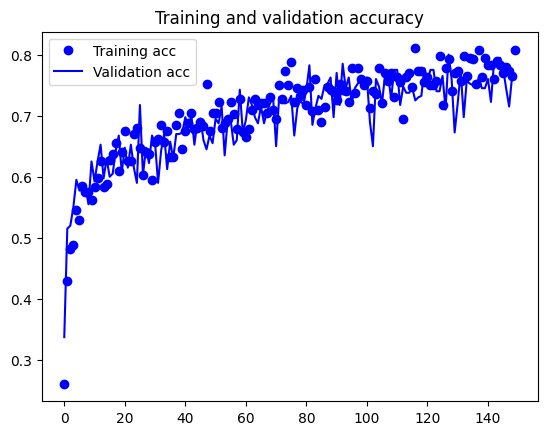

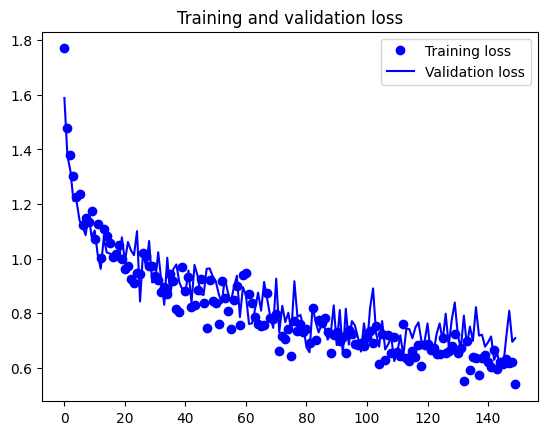

In [59]:
# Now, let's see if our model is overfitting
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

It looks like there is no significant overfitting in our model:

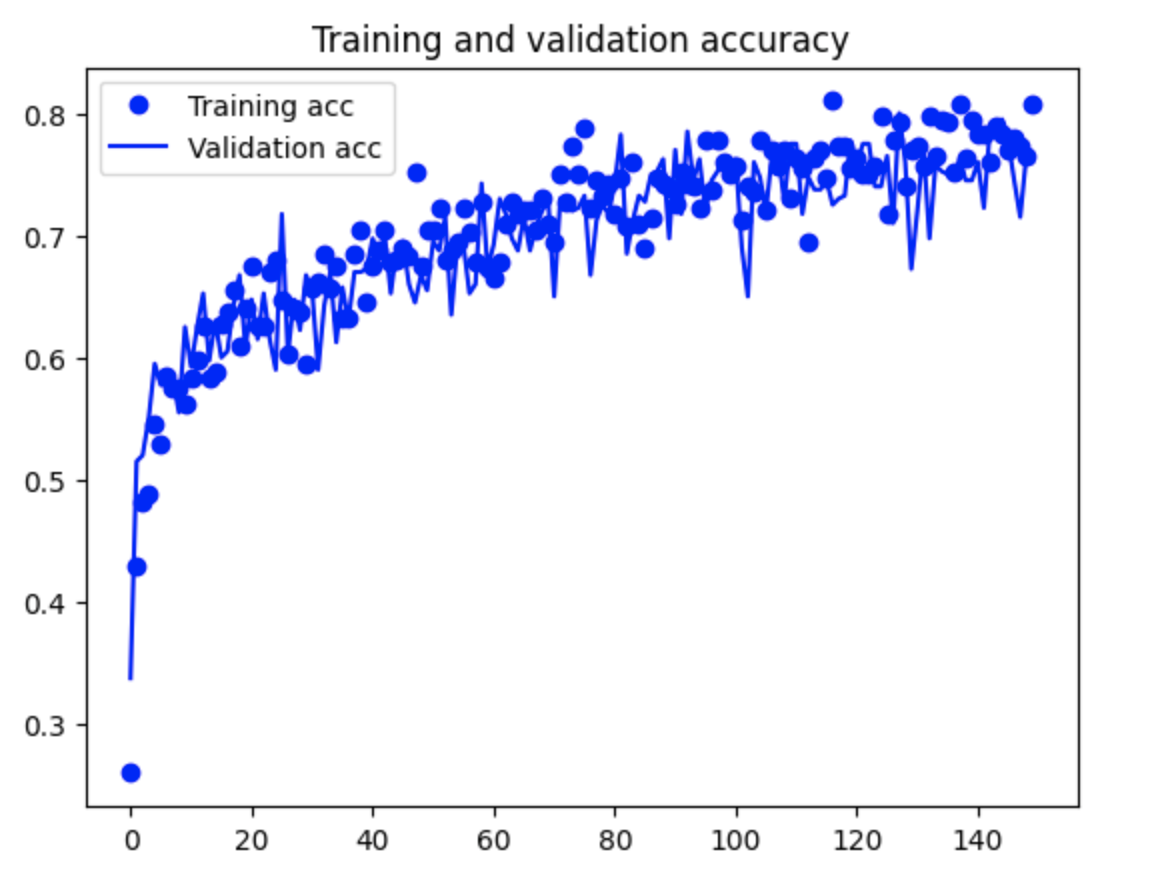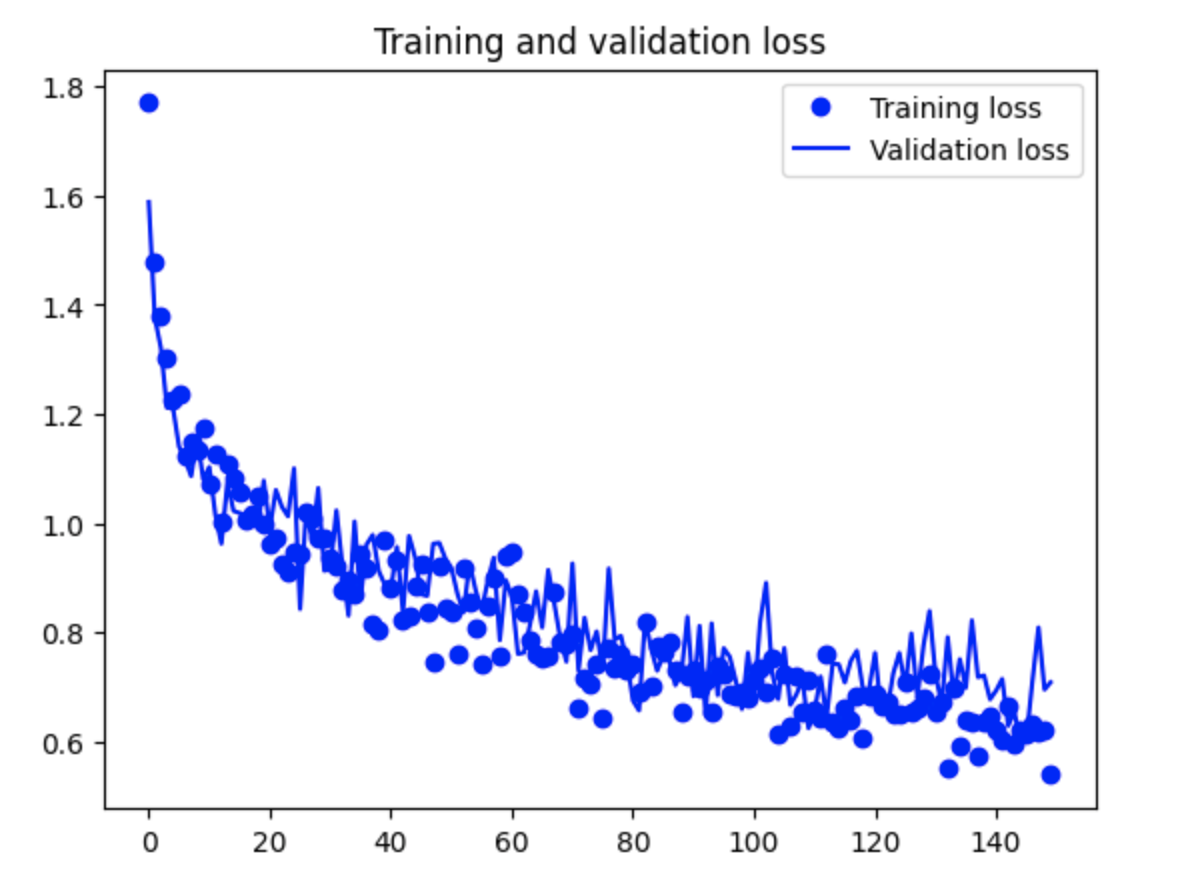

In [60]:
#Let's do predictions on our test data
scoreSeg = aug_model.evaluate(test_generator)
print("Accuracy: ", scoreSeg[1])

150/150 [==============================] - 51s 341ms/step - loss: 0.6436 - accuracy: 0.7853
Accuracy:  0.7853333353996277


In [61]:
# The accuracy on the test data was of 79%, which is not great. I'll work on optimizing the model after the first submission
# of this lab

In [62]:
# Now, I would like to try some of the images that don't have labels

These are the categories for reference:
{'buildings' -> 0, 
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

In [67]:
pred = aug_model.predict(validation_generator_2, batch_size=20)
pred.shape

366/366 [==============================] - 129s 352ms/step


(7301, 6)

In [76]:
# get the filenames in the seg_pred folder
# this didn't work since they weren't copied in the same order
# import os
# pic_tags = os.listdir('seg_pred')
# len(pic_tags)

7301

In [80]:
# I'm assuming that using filenames it would give me the names in the same order 
# as they were fed in the validation_generator.
# I would really love to learn more about how filenames work
file_tags=[]
for i in range(0, 7301):
    file_tags.append(validation_generator_2.filenames[i])

# print(file_tags)

['seg_pred/10004.jpg', 'seg_pred/10005.jpg', 'seg_pred/10012.jpg', 'seg_pred/10013.jpg', 'seg_pred/10017.jpg', 'seg_pred/10021.jpg', 'seg_pred/1003.jpg', 'seg_pred/10034.jpg', 'seg_pred/10038.jpg', 'seg_pred/10040.jpg', 'seg_pred/10043.jpg', 'seg_pred/10045.jpg', 'seg_pred/10047.jpg', 'seg_pred/10048.jpg', 'seg_pred/10052.jpg', 'seg_pred/10054.jpg', 'seg_pred/10059.jpg', 'seg_pred/10060.jpg', 'seg_pred/10066.jpg', 'seg_pred/10069.jpg', 'seg_pred/10073.jpg', 'seg_pred/10079.jpg', 'seg_pred/1008.jpg', 'seg_pred/10082.jpg', 'seg_pred/10083.jpg', 'seg_pred/10090.jpg', 'seg_pred/10092.jpg', 'seg_pred/10096.jpg', 'seg_pred/101.jpg', 'seg_pred/10100.jpg', 'seg_pred/10101.jpg', 'seg_pred/10102.jpg', 'seg_pred/10106.jpg', 'seg_pred/10109.jpg', 'seg_pred/10119.jpg', 'seg_pred/10124.jpg', 'seg_pred/10127.jpg', 'seg_pred/10129.jpg', 'seg_pred/10132.jpg', 'seg_pred/10133.jpg', 'seg_pred/10147.jpg', 'seg_pred/10157.jpg', 'seg_pred/10158.jpg', 'seg_pred/10159.jpg', 'seg_pred/1016.jpg', 'seg_pred/1016

In [81]:
import pandas as pd
# get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)
results = pd.DataFrame(pred, columns=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], dtype=float)
results['pic_tag'] = file_tags
results

,buildings,forest,glacier,mountain,sea,street,pic_tag
0,0.06454,0.01786,0.00036,0.00076,0.00012,0.91635,seg_pred/10004.jpg
1,0.00004,0.99974,0.00003,0.00006,0.00001,0.00013,seg_pred/10005.jpg
2,0.22639,0.00038,0.05134,0.22615,0.48595,0.00980,seg_pred/10012.jpg
3,0.03050,0.00031,0.10562,0.38442,0.39883,0.08032,seg_pred/10013.jpg
4,0.00163,0.99622,0.00000,0.00000,0.00000,0.00215,seg_pred/10017.jpg
...,...,...,...,...,...,...,...
7296,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,seg_pred/9988.jpg
7297,0.00526,0.00039,0.01676,0.85806,0.11624,0.00328,seg_pred/9992.jpg
7298,0.32913,0.00011,0.00024,0.00114,0.00352,0.66585,seg_pred/9993.jpg
7299,0.30729,0.00730,0.00434,0.01817,0.00540,0.65750,seg_pred/9995.jpg


In [84]:
results.loc[results['pic_tag']== 'seg_pred/302.jpg']

,buildings,forest,glacier,mountain,sea,street,pic_tag
4931,0.00448,0.00004,0.03547,0.02504,0.93424,0.00073,seg_pred/302.jpg


When I located that image (302) in the dataframe something seemed quite off to me. It said that there was 93% probability of it being "sea" when clearly, it was an image of a building. I decided to check that myself doing the steps below (displaying the image and then predicting with the model). Clearly the filename attribute, did not provide the names in order. I'm going to proceed to drop the pic_tag column from the dataframe, and test a few images individually as we did in the lab.

In [85]:
# load an image and convert it to an array
import keras.utils as image
import numpy as np

img_path = 'seg_pred/302.jpg'
img = image.load_img(img_path, target_size=(150, 150))

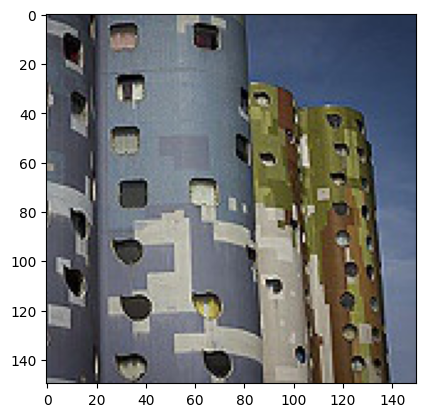

In [86]:
# Display image
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [87]:
# predict --> 78% of it being 'buildings'
aug_model.predict(img_tensor)

1/1 [==============================] - 0s 231ms/step


array([[0.77955544, 0.0014174 , 0.00200361, 0.00236741, 0.00488033,
        0.2097759 ]], dtype=float32)

In [90]:
# drop the pic_tag column from the df, since it clearly doesn't match 
# the prediction values
results = results.drop(['pic_tag'], axis=1)
results

,buildings,forest,glacier,mountain,sea,street
0,0.06454,0.01786,0.00036,0.00076,0.00012,0.91635
1,0.00004,0.99974,0.00003,0.00006,0.00001,0.00013
2,0.22639,0.00038,0.05134,0.22615,0.48595,0.00980
3,0.03050,0.00031,0.10562,0.38442,0.39883,0.08032
4,0.00163,0.99622,0.00000,0.00000,0.00000,0.00215
...,...,...,...,...,...,...
7296,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
7297,0.00526,0.00039,0.01676,0.85806,0.11624,0.00328
7298,0.32913,0.00011,0.00024,0.00114,0.00352,0.66585
7299,0.30729,0.00730,0.00434,0.01817,0.00540,0.65750


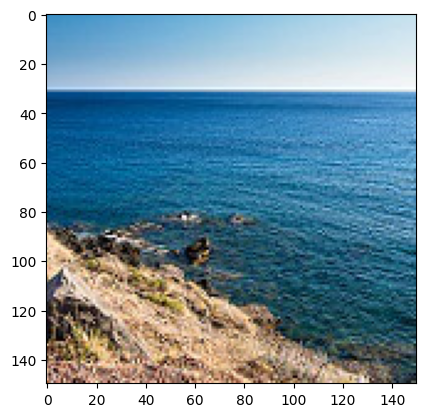

In [97]:
img_path = 'seg_pred/429.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()


In [98]:
# 98% certain that it's a picture of the sea yayyy!
aug_model.predict(img_tensor)

1/1 [==============================] - 0s 241ms/step


array([[2.62345828e-04, 1.33125093e-06, 1.07943534e-03, 1.05610145e-02,
        9.88093078e-01, 2.80456561e-06]], dtype=float32)

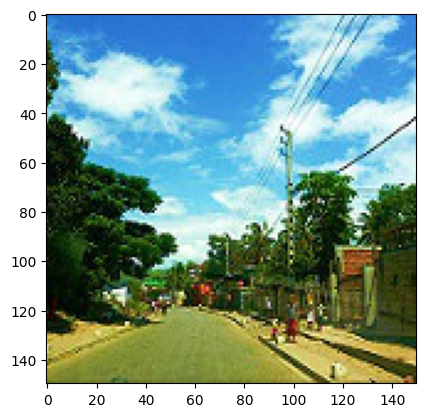

In [99]:
# another pic
img_path = 'seg_pred/13917.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()


In [100]:
# prediction - 95% certain that it is a mountain oops
aug_model.predict(img_tensor)

1/1 [==============================] - 0s 62ms/step


array([[1.8838637e-03, 8.3623180e-04, 2.3291761e-02, 9.5739096e-01,
        1.6410876e-02, 1.8631808e-04]], dtype=float32)

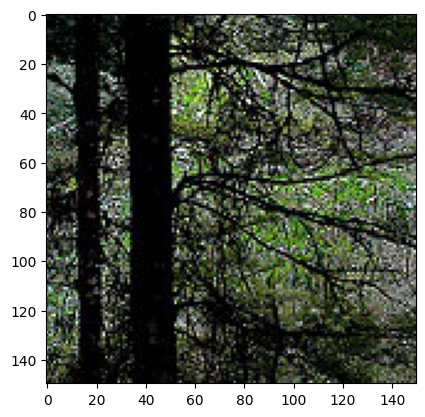

In [101]:
# 1 more
img_path = 'seg_pred/14380.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()


In [102]:
# prediction - 99% certain that it is a forest, not bad (:
aug_model.predict(img_tensor)

1/1 [==============================] - 0s 84ms/step


array([[6.3699539e-05, 9.9988723e-01, 7.7937821e-06, 4.7801582e-06,
        1.1330820e-06, 3.5426383e-05]], dtype=float32)